In [1]:
# DS4200
# Final Project
# Data Cleaning Portion

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Read in the files
resort_df = pd.read_csv("H1.csv")
city_df = pd.read_csv("H2.csv")

In [4]:
# Append the 2 datasets
# Create a column to differentiate the booking type (city, hotel)
resort_df["HotelType"] = "Resort"
city_df["HotelType"] = "City"

# Now conduct the merge
bookings_df = pd.concat((resort_df, city_df), axis=0)

# Filter the data down to 3 countries --> Spain, France, Italy
#country_lst = list("ESP", "FRA", "ITA")
bookings_df = bookings_df.loc[bookings_df["Country"].isin(["ESP", "FRA", "ITA"])]
print(set(bookings_df["Country"]))

{'FRA', 'ITA', 'ESP'}


In [5]:
# Remove whitespace to find NULL values
# and convert them to represent the NaN data type
bookings_df = bookings_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
bookings_df.replace("NULL", np.nan, inplace=True)

# Find the amount of NaN rows in the dataset 
# and remove them
null_rows = bookings_df[bookings_df.isnull().all(axis=1)]
#print(null_rows)  #32

null_idx = null_rows.index.to_list()
bookings_df = bookings_df.drop(index=null_idx)

# Find which column's have the highest prevalency
# of null values
for col in list(bookings_df.columns):
    null_amt = bookings_df[col].isnull().sum()
    pct = (null_amt / len(bookings_df)) * 100
    print(f"{col}: {round(pct, 3)}%")

IsCanceled: 0.0%
LeadTime: 0.0%
ArrivalDateYear: 0.0%
ArrivalDateMonth: 0.0%
ArrivalDateWeekNumber: 0.0%
ArrivalDateDayOfMonth: 0.0%
StaysInWeekendNights: 0.0%
StaysInWeekNights: 0.0%
Adults: 0.0%
Children: 0.0%
Babies: 0.0%
Meal: 0.0%
Country: 0.0%
MarketSegment: 0.0%
DistributionChannel: 0.0%
IsRepeatedGuest: 0.0%
PreviousCancellations: 0.0%
PreviousBookingsNotCanceled: 0.0%
ReservedRoomType: 0.0%
AssignedRoomType: 0.0%
BookingChanges: 0.0%
DepositType: 0.0%
Agent: 6.752%
Company: 97.631%
DaysInWaitingList: 0.0%
CustomerType: 0.0%
ADR: 0.0%
RequiredCarParkingSpaces: 0.0%
TotalOfSpecialRequests: 0.0%
ReservationStatus: 0.0%
ReservationStatusDate: 0.0%
HotelType: 0.0%


In [6]:
# Convert columns to Strings
string_cols = ["ArrivalDateMonth", "Meal", "Country", "MarketSegment",
               "DistributionChannel", "ReservedRoomType", "AssignedRoomType",
               "DepositType", "Agent", "CustomerType", "ReservationStatus", "HotelType"]
for col in string_cols:
    bookings_df[col] = bookings_df[col].astype(str)

# Convert column to Datetime objects
bookings_df["ReservationStatusDate"] = pd.to_datetime(bookings_df["ReservationStatusDate"])

In [7]:
# Based on the output above, it looks like the
# `Company` column is useless due to the high 
# percentage of NaN values
#bookings_df = bookings_df.drop("Company", axis=1)

# Replace NaN values in the `Agent` column
# with the most common
bookings_df["Agent"] = bookings_df["Agent"].replace("nan", np.nan)

mode_agent = bookings_df["Agent"].mode().iloc[0]
bookings_df["Agent"] = bookings_df["Agent"].fillna(mode_agent)

In [8]:
# create demographic features to focus on customer demographics and cancellation behavior 

# Create family demographic features
bookings_df['FamilySize'] = bookings_df['Adults'] + bookings_df['Children'] + bookings_df['Babies']
bookings_df['HasChildren'] = ((bookings_df['Children'] > 0) | (bookings_df['Babies'] > 0)).astype(int)

# Create demographic segments
conditions = [
    (bookings_df['Adults'] == 1) & (bookings_df['Children'] == 0) & (bookings_df['Babies'] == 0),
    (bookings_df['Adults'] == 2) & (bookings_df['Children'] == 0) & (bookings_df['Babies'] == 0),
    (bookings_df['HasChildren'] == 1)
]
choices = ['Solo', 'Couple', 'Family']
bookings_df['TravelerType'] = np.select(conditions, choices, default='Group')

In [9]:
# creates season based on arrival month for context
season_map = {
    'January': 'Winter', 'February': 'Winter', 'March': 'Spring',
    'April': 'Spring', 'May': 'Spring', 'June': 'Summer',
    'July': 'Summer', 'August': 'Summer', 'September': 'Fall',
    'October': 'Fall', 'November': 'Fall', 'December': 'Winter'
}
bookings_df['Season'] = bookings_df['ArrivalDateMonth'].map(season_map)

In [10]:
# creats business vs. leisure indication
# assumes that if in city and duration is short, then for a business trip (assumption) -> else unknown
conditions = [
    (bookings_df['HotelType'] == 'City') & (bookings_df['StaysInWeekNights'] >= 2) & (bookings_df['StaysInWeekendNights'] <= 1),
    (bookings_df['HotelType'] == 'Resort') | (bookings_df['StaysInWeekendNights'] >= 1)
]
choices = ['Business', 'Leisure']
bookings_df['TravelPurpose'] = np.select(conditions, choices, default='Unknown')

In [11]:
# for calculating total duration of time in hotel
# create stay duration feature
bookings_df['TotalStay'] = bookings_df['StaysInWeekendNights'] + bookings_df['StaysInWeekNights']

In [12]:
# checking distribution across countries and hotel types to make sure we dont have outliers in our data set skewing anythin 
print(bookings_df.groupby(['Country', 'HotelType'])['IsCanceled'].count())
print(bookings_df.groupby(['Country', 'HotelType'])['IsCanceled'].mean())

Country  HotelType
ESP      City         4611
         Resort       3957
FRA      City         8804
         Resort       1611
ITA      City         3307
         Resort        459
Name: IsCanceled, dtype: int64
Country  HotelType
ESP      City         0.287573
         Resort       0.215062
FRA      City         0.195706
         Resort       0.130975
ITA      City         0.378893
         Resort       0.174292
Name: IsCanceled, dtype: float64


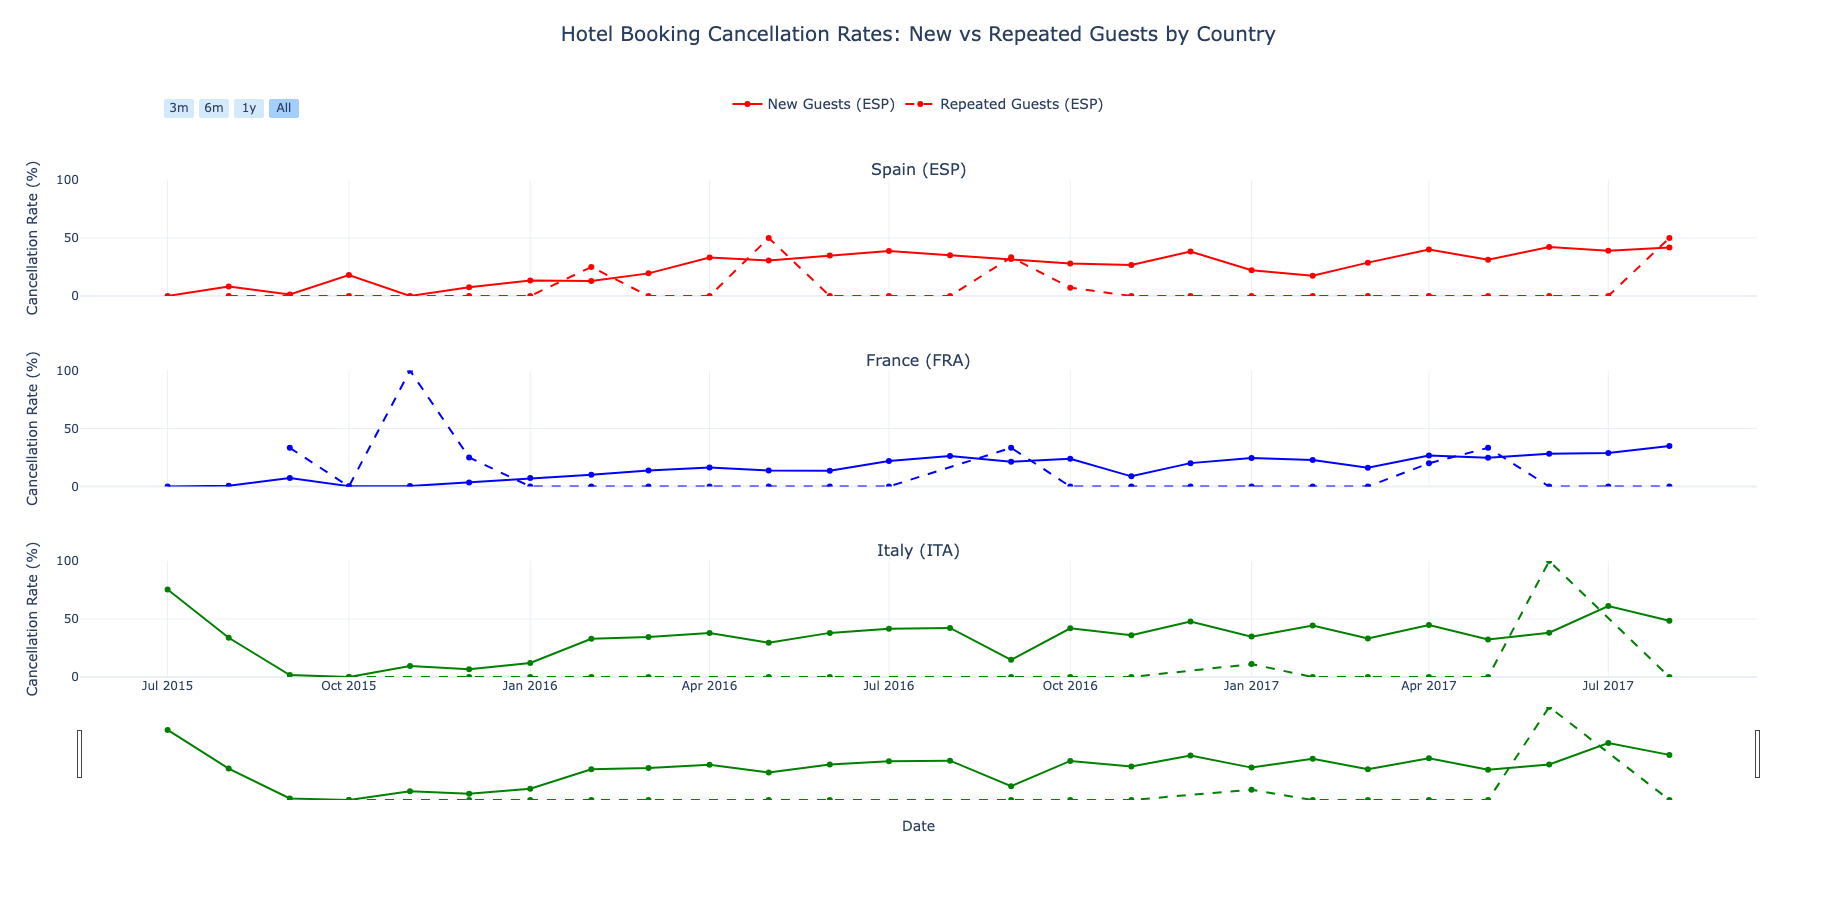

In [19]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# DATA PREP
# Create a datetime column for better plotting
bookings_df['date'] = pd.to_datetime(bookings_df['ArrivalDateYear'].astype(str) + '-' + 
                           bookings_df['ArrivalDateMonth'] + '-01')

# Function to calculate cancellation rates by country and guest type
def calculate_cancellation_by_country(df):
    # Group by country, date and repeated guest status
    result = df.groupby(['Country', 'date', 'IsRepeatedGuest']).agg({
        'IsCanceled': ['count', 'sum']
    }).reset_index()
    
    # Flatten the multi-index and rename columns
    result.columns = ['Country', 'date', 'IsRepeatedGuest', 'total_bookings', 'total_cancellations']
    
    # Calculate cancellation rate
    result['cancellation_rate'] = (result['total_cancellations'] / 
                                   result['total_bookings'] * 100)
    return result

# Calculate stats
cancellation_stats = calculate_cancellation_by_country(bookings_df)

# Create a figure with subplots - one row for each country
fig = make_subplots(
    rows=3, 
    cols=1,
    shared_xaxes=True,
    subplot_titles=("Spain (ESP)", "France (FRA)", "Italy (ITA)"),
    vertical_spacing=0.15  # Increased spacing between subplots
)

# Countries with specific colors as requested
countries = ['ESP', 'FRA', 'ITA']
country_colors = {'ESP': 'red', 'FRA': 'blue', 'ITA': 'green'}

# Add traces for each country in separate subplots
for i, country in enumerate(countries, 1):
    # Get data for new guests (IsRepeatedGuest = 0)
    new_data = cancellation_stats[
        (cancellation_stats['Country'] == country) & 
        (cancellation_stats['IsRepeatedGuest'] == 0)
    ]
    
    # Get data for repeated guests (IsRepeatedGuest = 1)
    repeated_data = cancellation_stats[
        (cancellation_stats['Country'] == country) & 
        (cancellation_stats['IsRepeatedGuest'] == 1)
    ]
    
    # Add trace for new guests - solid line
    fig.add_trace(
        go.Scatter(
            x=new_data['date'],
            y=new_data['cancellation_rate'],
            name=f'New Guests ({country})' if i == 1 else None,
            showlegend=i==1,
            mode='lines+markers',
            line=dict(color=country_colors[country], width=2, dash='solid'),  # Solid line
            marker=dict(size=6),
            hovertemplate='Date: %{x}<br>Cancellation Rate: %{y:.1f}%<extra></extra>'
        ),
        row=i, col=1
    )
    
    # Add trace for repeated guests - dashed line as requested
    fig.add_trace(
        go.Scatter(
            x=repeated_data['date'],
            y=repeated_data['cancellation_rate'],
            name=f'Repeated Guests ({country})' if i == 1 else None,
            showlegend=i==1,
            mode='lines+markers',
            line=dict(color=country_colors[country], width=2, dash='dash'),  # Dashed line 
            marker=dict(size=6),
            hovertemplate='Date: %{x}<br>Cancellation Rate: %{y:.1f}%<extra></extra>'
        ),
        row=i, col=1
    )
    
    # Update y-axis label
    fig.update_yaxes(title_text="Cancellation Rate (%)", row=i, col=1, range=[0, 100])

# Move filter buttons to more prominent position
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all", label="All")
        ]),
        y=1.1,  # Position higher up
        x=0.05,
        bgcolor='rgba(150, 200, 250, 0.4)',  # Light blue background
        font=dict(size=12)
    ),
    row=3, col=1
)

# Update shared x-axis title
fig.update_xaxes(title_text="Date", row=3, col=1)

# Update the legend positioning in your fig.update_layout section:
fig.update_layout(
    title=dict(
        text='Hotel Booking Cancellation Rates: New vs Repeated Guests by Country',
        x=0.5,
        xanchor='center',
        y=0.97,  # Move title up
        font=dict(size=20)  # Larger title font
    ),
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.12,  # Increased from 1.08 to move legend higher
        xanchor="center",
        x=0.5,
        font=dict(size=14),
        bgcolor='rgba(255, 255, 255, 0.8)'
    ),
    template='plotly_white',
    height=900,  # Increased height for better spacing
    margin=dict(l=80, r=80, t=180, b=100),  # Increased top margin from 150 to 180
)

# Show plot
fig.show()

fig.write_html("loyalty_plot_v2.html")

In [14]:
# Create an interactive plot, with Altair
# Family demographics, per country
import altair as alt
import datetime
import calendar
import warnings
warnings.filterwarnings("ignore")

# Disable maximum row limit in Altair
alt.data_transformers.disable_max_rows()

# Create a column with datetimes for the arrival date
datetime_objs = []
for idx,row in bookings_df.iterrows():
    # Convert the month name to an integer
    month_int = list(calendar.month_name).index(row["ArrivalDateMonth"])
    
    # Create a datetime object
    datetime_obj = datetime.datetime(year=int(row["ArrivalDateYear"]),
                                 month=month_int,
                                 day=int(row["ArrivalDateDayOfMonth"]))
    datetime_objs.append(datetime_obj)
    
bookings_df["ArrivalDatetime"] = datetime_objs



# Convert the dates to receive monthly averages for each country
bookings_df["ArrivalDatetime"] = pd.to_datetime(bookings_df["ArrivalDatetime"])
bookings_df["YearMonth"] = bookings_df["ArrivalDatetime"].dt.to_period("M")


# Aggregate ADR at the monthly level per country
# & convert YearMonth back to datetime for Altair plotting
agg_dct = {"ADR": "mean",
           "IsCanceled": "sum"
           #"Adults": "sum",
           #"Children": "sum",
           #"Babies": "sum"
          }
monthly_adr_df = bookings_df.groupby(["Country", "YearMonth", "TravelerType"], as_index=False).agg(agg_dct)
monthly_adr_df["YearMonth"] = monthly_adr_df["YearMonth"].dt.to_timestamp()

# Change the country names to prevent abbreviations from displaying
# in the legend
# Replace country abbreviations with full names
country_mapping = {
    "ESP": "Spain",
    "FRA": "France", 
    "ITA": "Italy"
}

# Apply the mapping to the Country column
monthly_adr_df["Country"] = monthly_adr_df["Country"].replace(country_mapping)



# In Altair, create the combined visualization
# Allow the user to select a Date range along the x-axis
date_selection = alt.selection_interval(encodings=['x'])

# Line chart of Monthly ADR
line_chart = alt.Chart(monthly_adr_df).mark_line().encode(
    x=alt.X("YearMonth:T", title="Month/Year", axis=alt.Axis(format="%b %Y")),  # month year format on x-axis
    y=alt.Y("mean(ADR):Q", title="Average Daily Rate (ADR)"),
    color=alt.condition(date_selection, "Country:N", alt.value("grey")),
    opacity=alt.condition(date_selection, alt.value(1), alt.value(0.3)),
    tooltip=["Country", "YearMonth", "mean(ADR):Q"],
).properties(
    title="Average Room Rates, per Month/Year"
).add_params(
    date_selection
)


# Bar chart of the Percentage of Cancelations, per Traveler Type
bar_chart = alt.Chart(monthly_adr_df).transform_filter(
    # For interval filtering
    date_selection
    
).transform_aggregate(
    TotalCancelations="sum(IsCanceled)",
    groupby=["TravelerType"]
    
).transform_window(
    TotalSum='sum(TotalCancelations)',
    frame=[None, None]  # wasn't working before
    
).transform_calculate(
    # Moving percentage
    PercentTotal="datum.TotalCancelations / datum.TotalSum"
    
).mark_bar().encode(
    x=alt.X("TravelerType:N", title="Traveler Type"),
    y=alt.Y("PercentTotal:Q", axis=alt.Axis(format='%'), title="Percentage of Cancellations"),
    #color=alt.Color("TravelerType:N"),
    tooltip=["TravelerType:N", "PercentTotal:Q"]
    
).properties(
    title="Percentage of Cancellations by Traveler Type"
)


chart = line_chart | bar_chart
chart

alt.HConcatChart(...)

### Analysis of the Interactive Line & Bar Plot:
    Based on the interactive visualization above, one could see that it's a joint graph between a line and bar plot. The reasoning behind this is to provide accurate insights behind what might be driving cancellation rates in hotels in Spain, Italy, and France - we can determine exploratory and explanatory insights from this visualization. The line plot measures average room rates respective to a specific month and year; for these values, the Average Daily Room Rate has been aggregated from a daily to a monthly rate, which maintains consistency with the date (independent variable). As for the specific trends that we can see, this relationship has been designated by the specific country the hotels pertain to. For example, we see a similar, potentially cyclical trend, that might hint at seasonality between the Summer and Winter months. It looks like that the room rates are at elevated values for Summer months, which suggests that demand might be higher during these months, due to factors like tourism. On a per country basis, it is hard to make a determinable conclusion other than the fact that Spain has had the highest Summer monthly rates (2016 & 2017) whereas they had the lowest Winter monthly rates (2015) and France also had the lowest (2017).
    As for the bar plot, this analysis is between traveler type and the percentage of cancellations respective to that type. Our motive to include this graph was to be able to understand, at specific periods, which types of travelers were cancelling reservations more so than the other groups. This plot updates per the selection interval the user makes in the line plot. Overall, though, we can clearly see that an overwhelming majority of cancellations stem from the "couple" traveler type. This is an interesting factor because it is at 70%, which is ~60% higher than the next respective type (family). This possibly suggests that couples have more freedom to move hotel bookings or a higher incentive to look for bargains and, therefore, cancel bookings that are too expensive/not worth it. This also suggests that, for the other types, it might be too difficult for families or solo travelers to cancel bookings: families typically have a lot of responsibilities and solo travelers might be highly correlated with business travel.

In [15]:
# Save Altair chart to html
chart.save("altair_advCancel.html")

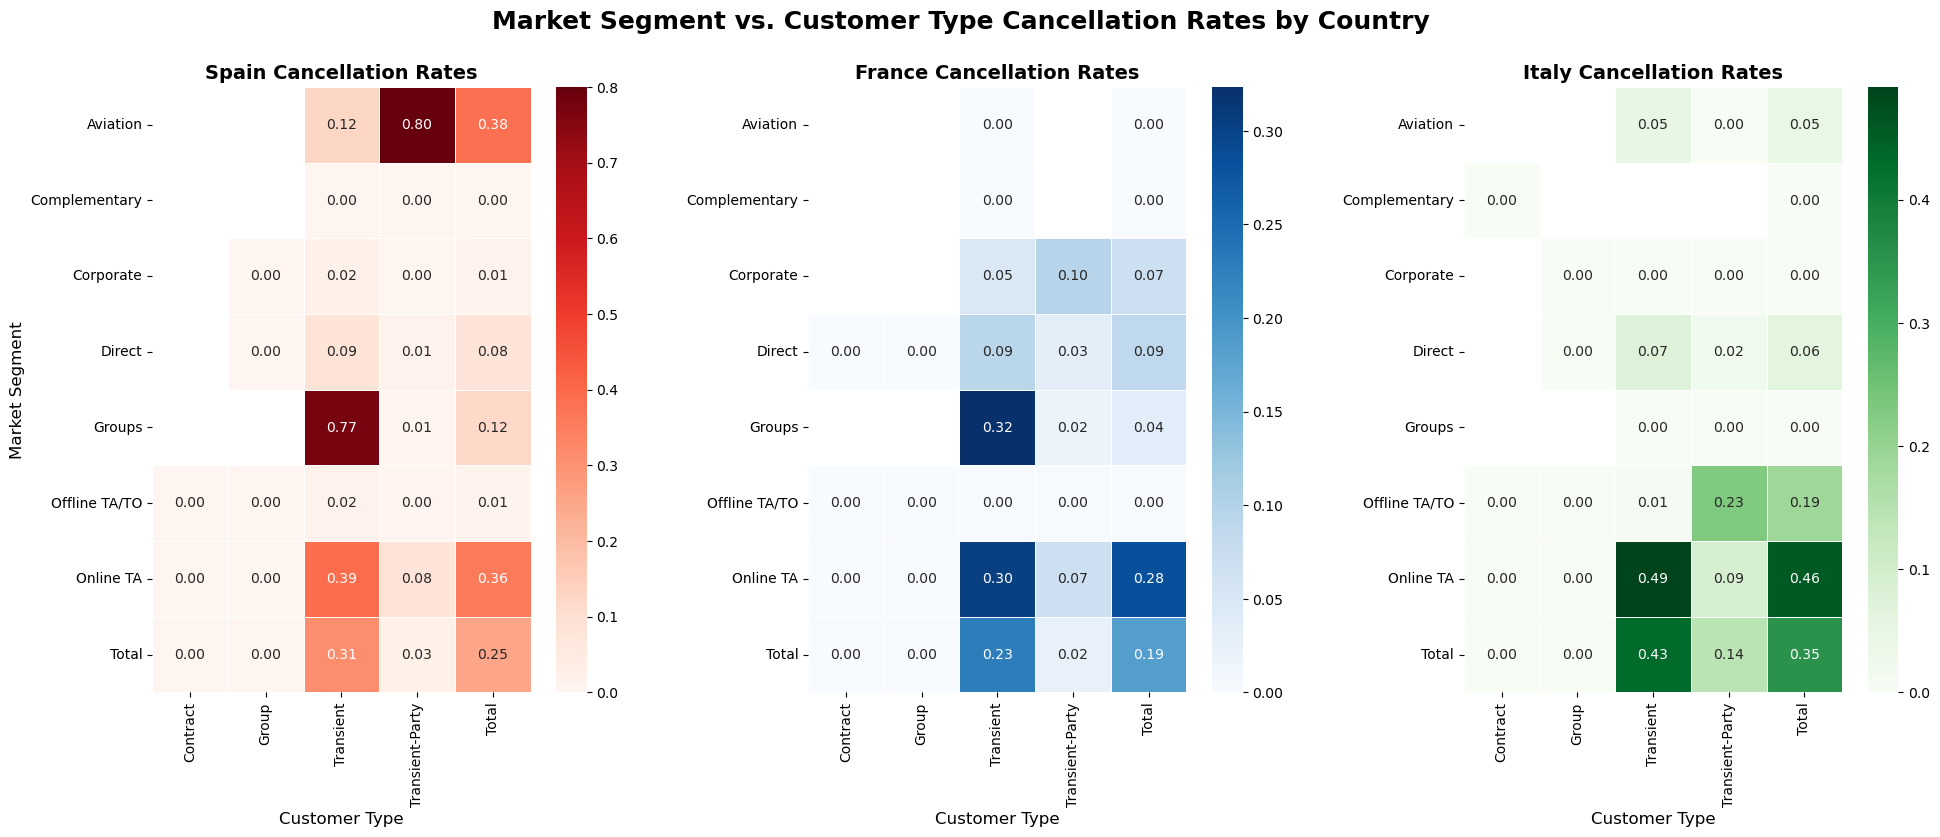

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Define the countries and their colors for visual consistency
countries = ['ESP', 'FRA', 'ITA']
country_names = ['Spain', 'France', 'Italy']
color_maps = ['Reds', 'Blues', 'Greens']  # Different color scheme for each country

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# For each country, create and plot its cancellation rate heatmap
for i, (country, country_name, cmap) in enumerate(zip(countries, country_names, color_maps)):
    # Filter for the current country
    country_df = bookings_df[bookings_df['Country'] == country]
    
    # Create pivot table for cancellation rates
    pivot_cancel_rate = pd.pivot_table(
        country_df,
        values='IsCanceled',
        index='MarketSegment',
        columns='CustomerType',
        aggfunc='mean',
        margins=True,
        margins_name='Total'
    )
    
    # Plot the heatmap
    sns.heatmap(
        pivot_cancel_rate,
        annot=True,
        fmt='.2f',
        cmap=cmap,
        cbar=True,
        linewidths=.5,
        square=True,
        ax=axes[i]
    )
    
    # Set titles and labels
    axes[i].set_title(f'{country_name} Cancellation Rates', fontsize=14, weight='bold')
    axes[i].set_xlabel('Customer Type', fontsize=12)
    
    # Only include y-axis label for the first subplot to avoid repetition
    if i == 0:
        axes[i].set_ylabel('Market Segment', fontsize=12)
    else:
        axes[i].set_ylabel('')

# Add a super title
plt.suptitle('Market Segment vs. Customer Type Cancellation Rates by Country', 
             fontsize=18, weight='bold', y=1.02)

# Adjust layout and save
plt.tight_layout()
plt.savefig('images/market_segmentation_by_country.png', dpi=300, bbox_inches='tight')
plt.show()